In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy

In [2]:
# load image data using ImageGenerator

#parameters
DIRECTORY = "Covid19-dataset/train"
CLASS_MODE = "categorical"
COLOUR_MODE = "grayscale"
TARGET_SIZE = (256, 256)
BATCH_SIZE = 32

RESCALE_FACTOR = 1.0/255
ZOOM_FACTOR = 0.15
ROTATION_FACTOR = 25
WIDTH_SHIFT_FACTOR = 0.05
HEIGHT_SHIFT_FACTOR = 0.05

training_data_generator = ImageDataGenerator(
    rescale=RESCALE_FACTOR,
    zoom_range=ZOOM_FACTOR,
    rotation_range=ROTATION_FACTOR,
    width_shift_range=WIDTH_SHIFT_FACTOR,
    height_shift_range=HEIGHT_SHIFT_FACTOR,
)

test_data_generator = ImageDataGenerator()

In [3]:
# iterator objects to represent training and test sets
training_set = training_data_generator.flow_from_directory(DIRECTORY, class_mode=CLASS_MODE, color_mode=COLOUR_MODE, batch_size=BATCH_SIZE)

training_set.next()

print("Loading validation data...\n")

test_set = test_data_generator.flow_from_directory(DIRECTORY, class_mode=CLASS_MODE, color_mode=COLOUR_MODE, batch_size=BATCH_SIZE)

Found 251 images belonging to 3 classes.
Loading validation data...

Found 251 images belonging to 3 classes.


In [4]:
# create a classification NN model

print("Model building in process...\n")

def design_model(training_data):
    model = Sequential()

    # image input layer 
    model.add(tf.keras.Input(shape=(256, 256, 1)))

    # convolutional hidden layers 
    model.add(layers.Conv2D(5, 5, strides=3, activation="relu"))

    # max pooling layer
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # dropout layer
    model.add(layers.Dropout(0.1))

    # convolutional hidden layers 
    model.add(layers.Conv2D(3, 3, strides=1, activation="relu"))

    # max pooling layer
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # dropout layer
    model.add(layers.Dropout(0.2))

    # flatten layers
    model.add(layers.Flatten())

    # softmax 
    model.add(layers.Dense(3, activation="softmax"))

    # compile model with Adam gradient descent optimizer, categorical cross entropy loss function, categorical accuracy and AUC metrics
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=.005), 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()])

    # summarize
    model.summary()

    return model

    
    

Model building in process...



In [5]:
# use model function
model = design_model(training_set)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 84, 84, 5)         130       
                                                                 
 max_pooling2d (MaxPooling2  (None, 42, 42, 5)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 42, 42, 5)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 3)         138       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 3)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 3)         0

In [6]:
# early stopping
es = EarlyStopping(monitor='val_auc', mode='min', verbose=1, patience=20)

print('Training model...\n')

# fit the model 
history = model.fit(
          training_set,
          steps_per_epoch=training_set.samples/BATCH_SIZE, 
          epochs=10,
          validation_data=test_set,
          validation_steps=test_set.samples/BATCH_SIZE,
          callbacks=[es])
          

Training model...

Epoch 1/10
7/7 [==============================] - 2s 261ms/step - loss: 1.1423 - categorical_accuracy: 0.4183 - auc: 0.5331 - val_loss: 6.0336 - val_categorical_accuracy: 0.4104 - val_auc: 0.5679
Epoch 2/10
7/7 [==============================] - 2s 213ms/step - loss: 1.0677 - categorical_accuracy: 0.4462 - auc: 0.6157 - val_loss: 9.0686 - val_categorical_accuracy: 0.4542 - val_auc: 0.6184
Epoch 3/10
7/7 [==============================] - 2s 239ms/step - loss: 0.9740 - categorical_accuracy: 0.5657 - auc: 0.7569 - val_loss: 4.8297 - val_categorical_accuracy: 0.8606 - val_auc: 0.9067
Epoch 4/10
7/7 [==============================] - 2s 212ms/step - loss: 0.7295 - categorical_accuracy: 0.6773 - auc: 0.8622 - val_loss: 21.4592 - val_categorical_accuracy: 0.8526 - val_auc: 0.8948
Epoch 5/10
7/7 [==============================] - 2s 208ms/step - loss: 0.5155 - categorical_accuracy: 0.7888 - auc: 0.9267 - val_loss: 30.4603 - val_categorical_accuracy: 0.8924 - val_auc: 0.9221

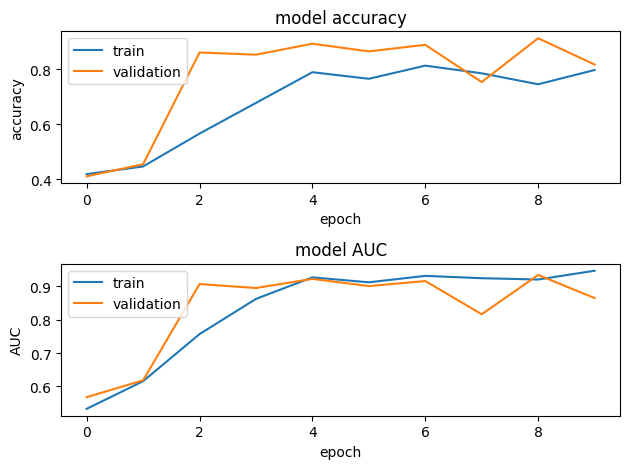

In [7]:
# plotting categorical and validation accuracy over epochs
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['auc'])
ax2.plot(history.history['val_auc'])
ax2.set_title('model AUC')
ax2.set_xlabel('epoch')
ax2.set_ylabel('AUC')
ax2.legend(['train', 'validation'], loc='upper left')

fig.tight_layout()

plt.show()

In [8]:
test_steps_per_epoch = numpy.math.ceil(test_set.samples / test_set.batch_size)
predictions = model.predict(test_set, steps=test_steps_per_epoch)
test_steps_per_epoch = numpy.math.ceil(test_set.samples / test_set.batch_size)
predicted_classes = numpy.argmax(predictions, axis=1)
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

8/8 [==============================] - 1s 79ms/step
              precision    recall  f1-score   support

       Covid       0.44      0.34      0.39       111
      Normal       0.31      0.47      0.38        70
   Pneumonia       0.31      0.26      0.28        70

    accuracy                           0.35       251
   macro avg       0.35      0.36      0.35       251
weighted avg       0.37      0.35      0.35       251

[[38 47 26]
 [22 33 15]
 [26 26 18]]
